 We import slightly cleaned up versions of human mortality data available on the Human Mortality Database: https://www.mortality.org/Data/DataAvailability

 Namely, we look at the Death Counts data for all available countries (only ~40, note), which give us for each year and age the number of
 individuals in the given country that died at that age in the given year. We restrict to ages >= 10 and years >= 2000. 
 Ages >=110 are all grouped into age 110 in the HMD.

We then process the data by country and plot a graph of number of deaths as a function of age

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gumbel_l, gumbel_r  # For the left-skewed (min) Gumbel distribution
from scipy.stats import probplot

# Suppress all (deprecation) warnings
warnings.filterwarnings("ignore")

countries = ["AUS", "AUT", "BGR", "BLR", "CAN", "CHE", "CHL", "CZE", "DEUTNP", "DNK", "ESP", "EST", "FIN", "GBRTENW", 
             "GRC", "HKG", "HRV", "HUN", "IRL", "ISL", "ISR", "ITA", "JPN", "KOR", "LTU", "LUX", "LVA", "NLD", "NOR", 
             "NZL_NP", "POL", "PRT", "RUS", "SVK", "SVN", "SWE", "UKR", "USA"] #something wrong with BEL file, skipped

for s in countries:   
    df = pd.read_csv(f"{s}.Deaths_1x1.txt", delim_whitespace = True)

    # Save as CSV
    df.to_csv("output.csv", index=False)

    # the data files have columns "Male", "Female", "Total". We will focus only on "Total".
    df.drop(["Female", "Male"], axis=1, inplace = True)
    df = df[df["Year"] >= 2000]
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")  # Converts to numeric, NaN for invalid entries

    # Restrict to ages >= 10
    df = df[df["Age"] >= 10]

    # Group by 'age' and sum the 'number' values across all years
    df = df.groupby("Age")["Total"].sum().reset_index()

    # plot Total number as function of Age
    plt.figure(figsize=(4, 3))
    plt.plot(df["Age"], df["Total"], linestyle="-", color="b")

    # Set plot labels and title
    plt.xlabel("Age")
    plt.ylabel("Total")
    plt.title(s)

    # Show the plot
    plt.show()

Here are some of the graphs:

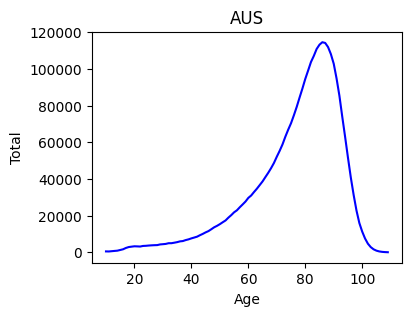  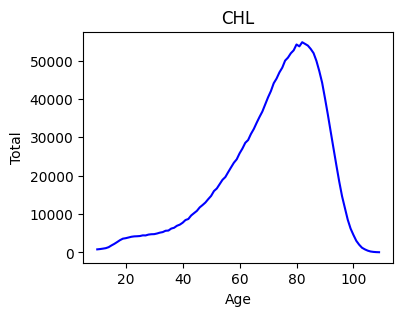   

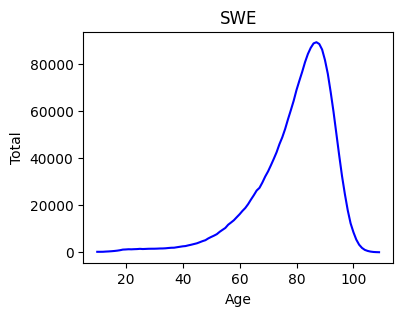 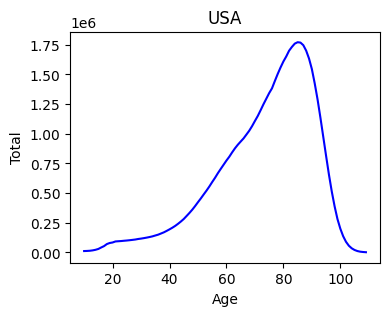

Here is Luxembourg, with its relatively tiny population:


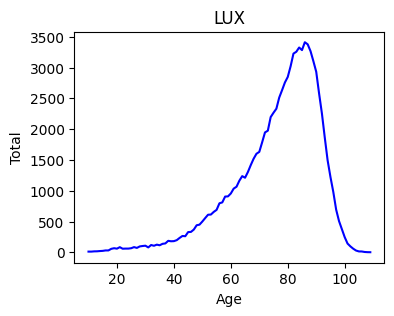

These totals clearly follow a **Gumbel distribution**. More precisely, these graphs look lower Gumbel distributed (or "min Gumbel"). These distributions arise in extreme value theory, and in the case of the min Gumbel distribution, what is being measured is the weakest component failure in a system.

The max Gumbel distribution is more widely used, and we achieve that for our data by simply putting a minus sign in front of our Age parameter.

The pdf of a max Gumbel distribution is given by $f(x) = \frac{1}{\beta} e^{-z - e^{-z}}$, where $z = \frac{x - \mu}{\beta}$. Here $\mu$ and $\beta$ are the location and scale parameters, respectively. The mean and standard deviation are linear combinations of $\mu, \beta$. Namely, the mean is given by $\mu + \beta \gamma$, where $\gamma$ is the Euler-Mascheroni constant; the variance is given by $\frac{\pi^2}{6}\beta^2$ (where $\frac{\pi^2}{6}$ is the Basel constant). 

We can therefore estimate the parameters of our max Gumbel distribution from our sample means and sample variances.

We keep track of $\mu$, $\beta$, mean, and variance for each country in the array parameters_list. We also record, as the last parameter in parameters_list, the GDP per capita in 2023 for each country. This data is collected from World Bank Group, https://data.worldbank.org/indicator/NY.GDP.PCAP.CD .


In [55]:

# The above was preliminary, just to see the graphs. Now we go through the countries again and calculate the corresponding approximate parameters
# for the Gumbel distribution.

parameter_list = []  #each entry is [country code, mu, beta, mean, variance, gdp per capita]

countries = ["AUS", "AUT", "BGR", "BLR", "CAN", "CHE", "CHL", "CZE", "DEUTNP", "DNK", "ESP", "EST", "FIN", "GBRTENW", "GRC",
             "HKG", "HRV", "HUN", "IRL", "ISL", "ISR", "ITA", "JPN", "KOR", "LTU", "LUX", "LVA", "NLD", "NOR", "NZL_NP", "POL", "PRT", "RUS", "SVK", "SVN", "SWE", "UKR", "USA"]

# removed ["LUX", "IRL", "USA", "RUS"] outliers

test_countries = ["AUS", "AUT", "BGR"]  #included in the list of all countries for now; we will ignore these first entries when we start analyzing

# gdp per capita by country code
#              
gdp_dct = {"AUS": 64821, "AUT": 56034, "BGR": 15886, "BLR": 7829, "CAN": 53431, "CHE": 99565, "CHL": 17068, "CZE": 31591, "DEUTNP": 54343, 
       "DNK": 68454, "ESP": 33509, "EST": 30133, "FIN": 52926, "GBRTENW": 49464, "GRC": 23401, "HKG": 50532, "HRV": 21866, "HUN": 22142, "IRL": 103888,
       "ISL": 79637, "ISR": 52642, "ITA": 39003, "JPN": 33767, "KOR": 33121, "LTU": 27786, "LUX": 128678, "LVA": 22501, "NLD": 64572, "NOR": 87925,
       "NZL_NP": 48281, "POL": 22057, "PRT": 36779, "RUS": 13817, "SVK": 24491, "SVN": 32610, "SWE": 55517, "UKR": 5070, "USA": 82769}      


for s in countries:  
    #print(s)
    df = pd.read_csv(f"{s}.Deaths_1x1.txt", delim_whitespace = True)

    # Save as CSV
    df.to_csv("output.csv", index=False)
    df.drop(["Female", "Male"], axis=1, inplace = True)
    df = df[df["Year"] >= 2000]
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")  # Converts to numeric, NaN for invalid entries
    df = df[df["Age"] >= 10]
    # Group by 'age' and sum the 'number' values across all years
    #print(df.head())
    df = df.groupby("Age")["Total"].sum().reset_index()
    
    df["Age"] = -df["Age"]


    # Compute sum of age * total
    weighted_sum = 0
    weighted_sum_squares = 0
    total_count = 0

    for _, row in df.iterrows():
        weighted_sum += row['Age'] * row['Total']
        weighted_sum_squares += (row['Age']**2) * row['Total']
        total_count += row['Total']

    # Compute sample mean
    sample_mean = weighted_sum / total_count if total_count > 0 else 0
    sample_var = (total_count*weighted_sum_squares - weighted_sum**2)/(total_count**2)

    gamma = 0.5772156649015329 # euler-mascheroni

    beta = math.sqrt(6*sample_var/(math.pi**2))
    mu = sample_mean - beta*gamma

    mean, var = sample_mean, sample_var

    parameter_list.append([s,mu,beta,mean,var])
    
   


for i in range(len(parameter_list)):
    parameter_list[i].append(gdp_dct[parameter_list[i][0]])
    parameter_list[i][1] = float(parameter_list[i][1])
    



In [ ]:
data = parameter_list[3:]  #ignore the test countries
df = pd.DataFrame(data, columns=["country", "mu", "beta", "mean", "variance", "gdp"])

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

#3D scatterplot
# Extract (mu, beta) as the independent variables (X) and GDP as the dependent variable (y)
X = np.array([[mean, var] for _, _, _, mean, var, _ in data])   # code, mu, beta, mean, var, gdp
y = np.array([gdp for _, _, _, _, _, gdp in data])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with mu, beta on x, y axes and GDP on z-axis
ax.scatter(X[:, 0], X[:, 1], y, c='blue', marker='o')

ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.set_zlabel('gdp')
ax.set_title('GDP per capita against (negative) sample mean and sample variance')



ax.view_init(elev=45, azim=45)

plt.show()  # Final show to keep the plot open after rotation

We plot GDP per capita against the mean and variance. This is a bit backwards (surely GDP is the one influencing life expectancy), but it will give us an idea of their relationship.

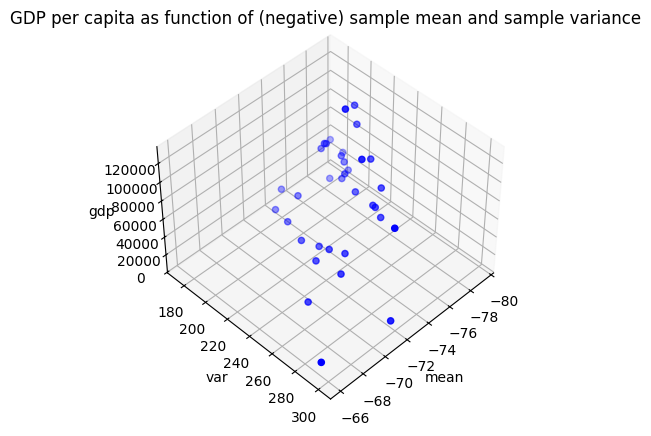

Here we see scatterplots of the GDP per capita against the mean, variance, $\mu$\, $\beta$:

In [ ]:
y = np.array([gdp for _, _, _, _, _, gdp in data])
X = np.array([mean for _, _, _, mean, _, _ in data])   # country code, mu, beta, mean, var, gdp
#X = np.array([var for _, _, _, _, var, _ in data])   # for var
#X = np.array([mu for _, mu, _, _, _, _ in data])   # for mu
#X = np.array([beta for _, _, beta, _, _, _ in data])   # for beta



# creating scatter plot
plt.scatter(X, y, color='blue')
plt.xlabel('gdp per capita')
plt.ylabel('mean')
plt.legend()
plt.show()

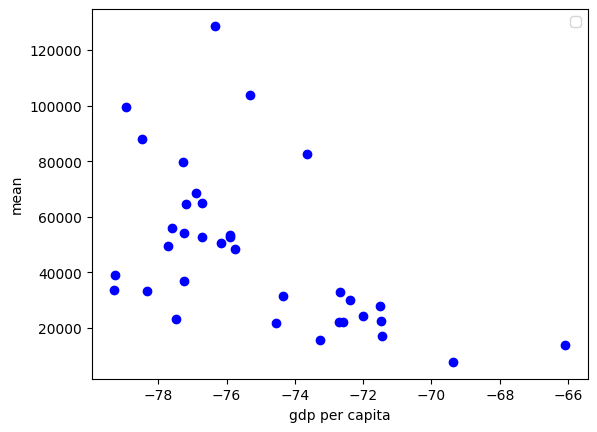    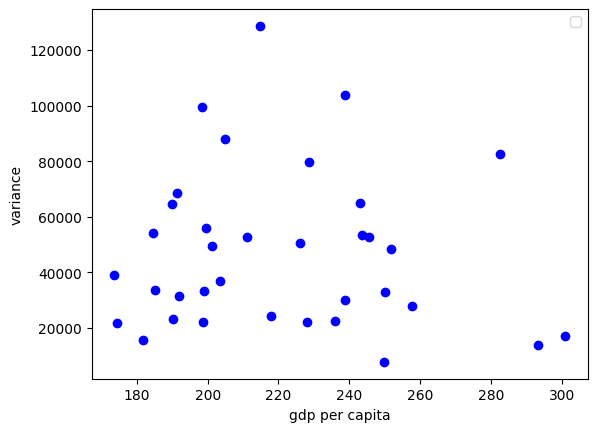

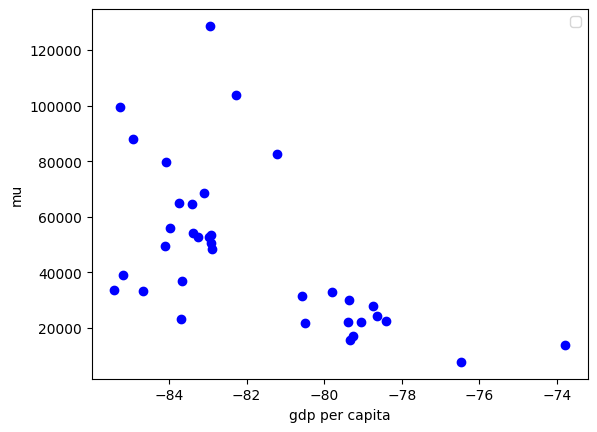    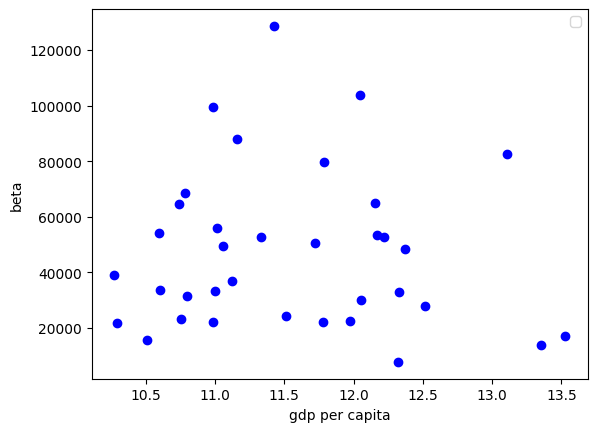

Beta and the variance seem uncorrelated with GDP per capita. Indeed:

In [ ]:
print("Correlation of beta with GDP:", np.corrcoef(np.array([beta for _, _, beta, _, _, _ in data]), y)[0,1])
print("Correlation of sample variance with GDP:", np.corrcoef(np.array([var for _, _, _, _, var, _ in data]), y)[0,1])
print("Correlation of mu with GDP:", np.corrcoef(np.array([mu for _, mu, _, _, _, _ in data]), y)[0,1])
print("Correlation of sample mean with GDP:", np.corrcoef(np.array([mean for _, _, _, mean, _, _ in data]), y)[0,1])


Correlation of beta with GDP: -0.058016638152794384
Correlation of sample variance with GDP: -0.06984319280166225
Correlation of mu with GDP: -0.5797613077147825
Correlation of sample mean with GDP: -0.5342233313519176

Recall that mean here is negative the actual mean. Let us consider this positive correlation between mean and GDP per capita more.

First we make a scatterplot of the mean (without minus sign now) against the GDP per capita.

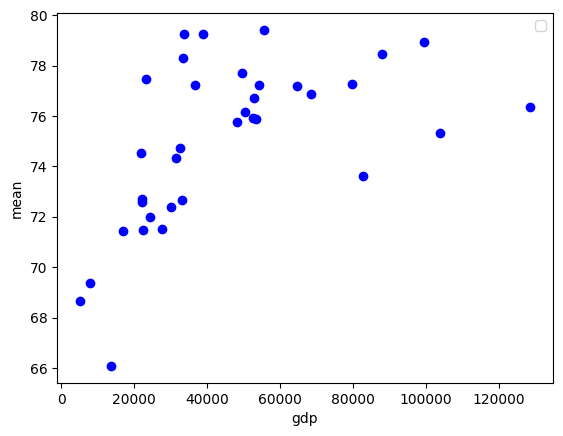

In [58]:
#import numpy as np
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score

X = np.array([gdp for _, _, _, _, _, gdp in data])
y = np.array([-mean for _, _, _, mean, _, _ in data])   # code, mu, beta, mean, var, gdp

plt.scatter(X, y, color='blue')
plt.xlabel('gdp')
plt.ylabel('mean')
plt.legend()
plt.show()





The data looks logarithmically distributed. There also seems to be some sort of grouping going on, with two groups separated by the bottom-left to top-right diagonal. With more data this would be interesting to explore, but for now we treat the four point below the diagonal as outliers: these are Luxembourg (LUX), Ireland (IRL), Russia (RUS), and the USA. 

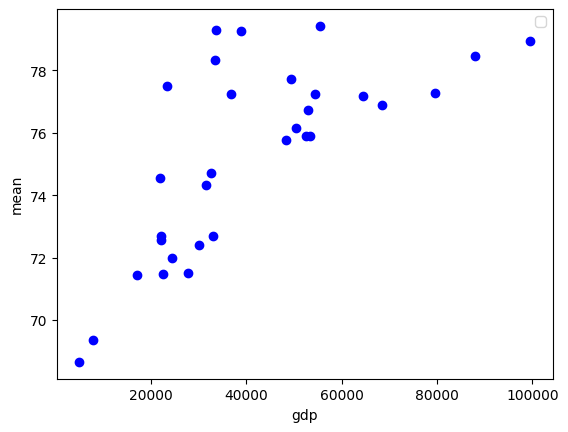

In [59]:
data = [datum for datum in data if datum[0] not in {"LUX","IRL","RUS","USA"}]
        
X = np.array([gdp for _, _, _, _, _, gdp in data])
y = np.array([-mean for _, _, _, mean, _, _ in data])   # code, mu, beta, mean, var, gdp

plt.scatter(X, y, color='blue')
plt.xlabel('gdp')
plt.ylabel('mean')
plt.legend()
plt.show()



We now fit a function of the form $a+b \cdot ln(x)$ through our data (minimizing MSE). First we sort the x-axis to make a nicer looking output.

Logarithmic fit R2: 0.633


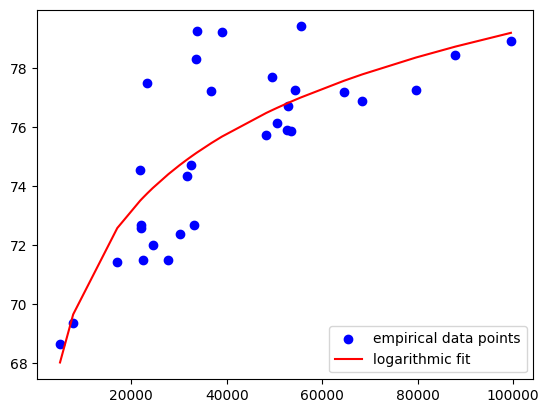

Fitted parameters: a = 35.96214026743795, b = 3.757682293304541


In [60]:
sorted_pairs = sorted(zip(X, y))  # Creates sorted pairs (X, Y)
X_sorted, y_sorted = zip(*sorted_pairs)  # Unzips into separate lists

X = list(X_sorted)
y = list(y_sorted)


def log_func(x, a, b):
    return a + b * np.log(x)

params, _ = curve_fit(log_func, X, y)
y_pred = log_func(X, *params)
r2 = r2_score(y, y_pred)

print(f"Logarithmic fit R2: {r2:.3f}")

plt.scatter(X, y, color="blue", label="empirical data points")
plt.plot(X, y_pred, color="red", label="logarithmic fit")
plt.legend()
plt.show()

print(f"Fitted parameters: a = {params[0]}, b = {params[1]}")

Let us now predict the mean for our small test set of Australia (AUS), Austria (AUT), and Bulgaria (BLG):

In [63]:
a = params[0]
b = params[1]

for country in parameter_list[:3]:
    print(country[0])
    print("Actual average age", -country[3])
    print("Predicted average age", a + b * np.log(country[5]), "\n")

AUS
Actual average age 76.7305243965844
Predicted average age 77.5949487415804 

AUT
Actual average age 77.60077742405574
Predicted average age 77.04756349601004 

BGR
Actual average age 73.26038540586765
Predicted average age 72.31092819154901 

